In [15]:
import pickle
import os

FOLDER = os.getcwd() + "/10_pts"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time



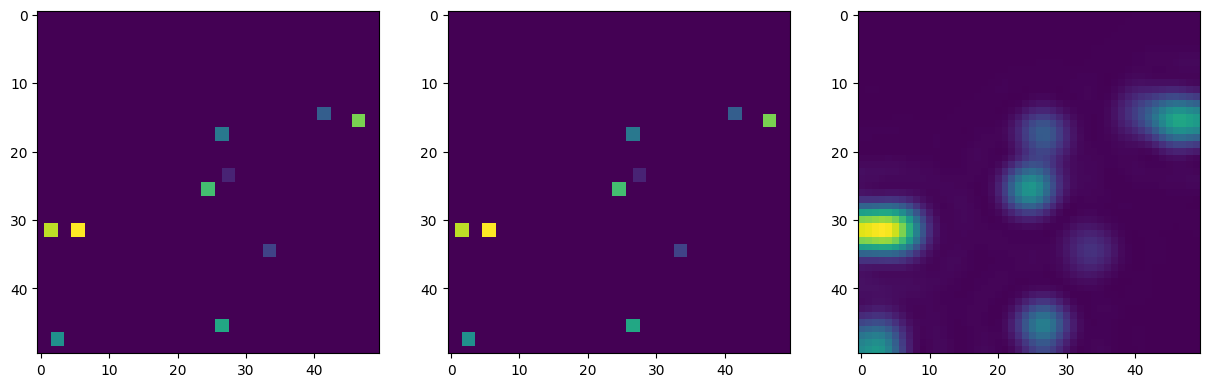

In [17]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [18]:
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

with open(FOLDER + '/sourcePts.pkl', 'wb') as file: 
    pickle.dump(sourcePts, file)

"""
for k in sourcePts:
    plt.scatter(k[1],k[0],c='r')
plt.imshow(mask)
"""


40


"\nfor k in sourcePts:\n    plt.scatter(k[1],k[0],c='r')\nplt.imshow(mask)\n"

In [19]:
def AverageFilter(img, x, y):
    sz = [ -2, -1, 0 , 1, 2]
    total = 0
    for i in sz:
        for j in sz:
            if x+i >= 0 and x+i < len(img) and y+j >= 0 and y+j < len(img[0]):
                total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
(outputWidth, outputHeight) = out.shape
N = len(sourcePts)
distanceMatrix= []
intensityMatrix = []
maskSize = euclideanDistance(mask.shape,(0,0)) 

for idx in range(N):
    current = sourcePts[idx]
    distance = [euclideanDistance(sourcePts[k],current)/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,current[0],current[1])/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Add a bunch of random points
for i in range(outputWidth*outputHeight//2):
    x = random.randint(0,maskWidth-1)
    y = random.randint(0,maskHeight-1)
    distance = [euclideanDistance(sourcePts[k],(x,y))/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,x,y)/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Convert to tensor
distanceMatrix = torch.stack(distanceMatrix)
intensityMatrix = torch.stack(intensityMatrix)

In [22]:
#Create custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, distanceMatrix, intensityMatrix):
        self.distanceMatrix = distanceMatrix
        self.intensityMatrix = intensityMatrix
    def __len__(self):
        return len(self.intensityMatrix)

    def __getitem__(self, idx):
        return (self.distanceMatrix[idx], self.intensityMatrix[idx]) 
dataset = CustomDataset(distanceMatrix, intensityMatrix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

In [23]:
class Net(nn.Module):
    def __init__(self,N,output_intensity=None):
        super(Net, self).__init__()
        self.psf_weights = nn.Sequential(
            nn.Linear(1,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,1),
            nn.Sigmoid()
        )
        self.actual_intensity = nn.Linear(N,1,bias=False)
        if output_intensity is not None:
            for i in range(N):
                self.actual_intensity.weight.data[0][i] = output_intensity[i]
    def getPSF(self,x):
        x = x.unsqueeze(2) 
        x = self.psf_weights(x)
        x = x.squeeze(2)
        return x
        
    def forward(self, x):
        x = self.getPSF(x)
        x = self.actual_intensity(x)
        return x


In [24]:
model = Net(N,intensityMatrix.data.flatten())
model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
#model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
model.zero_grad()

#Define loss function and optimizer
criterion = nn.MSELoss()
#criterion = nn.HuberLoss(delta=0.1)
optimizer = optim.SGD([
                    {'params': model.psf_weights.parameters(), 'lr': 0.001},
                    {'params': model.actual_intensity.parameters(), 'lr': 0.001}
                ], lr=0.001, momentum=0.9)

Epoch:  1  Loss:  78.48623275756836


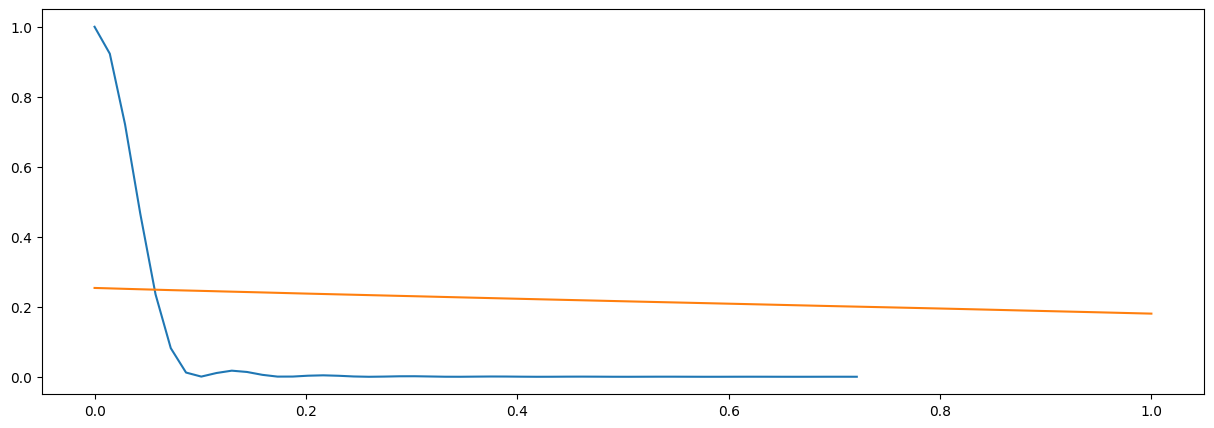

Epoch:  51  Loss:  0.043273162096738815


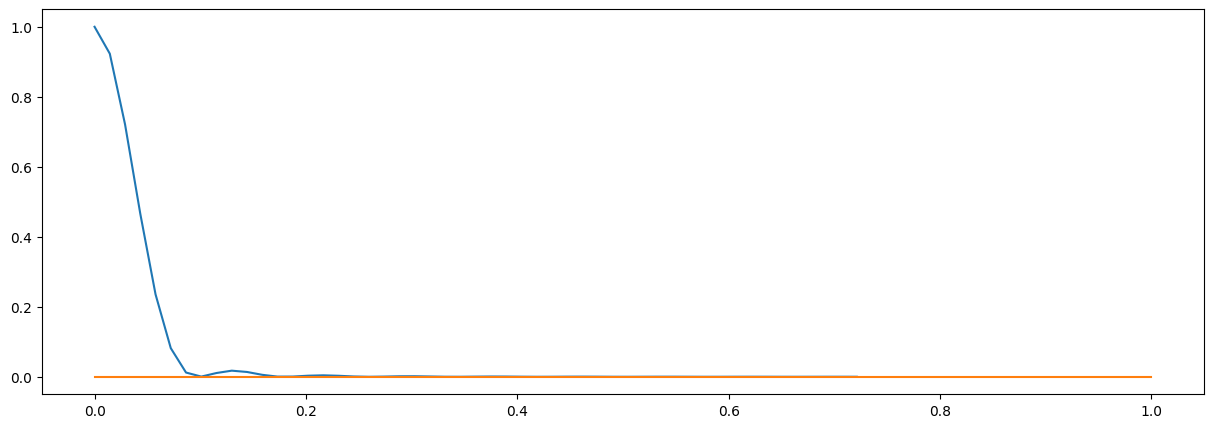

Epoch:  101  Loss:  0.036630356684327126


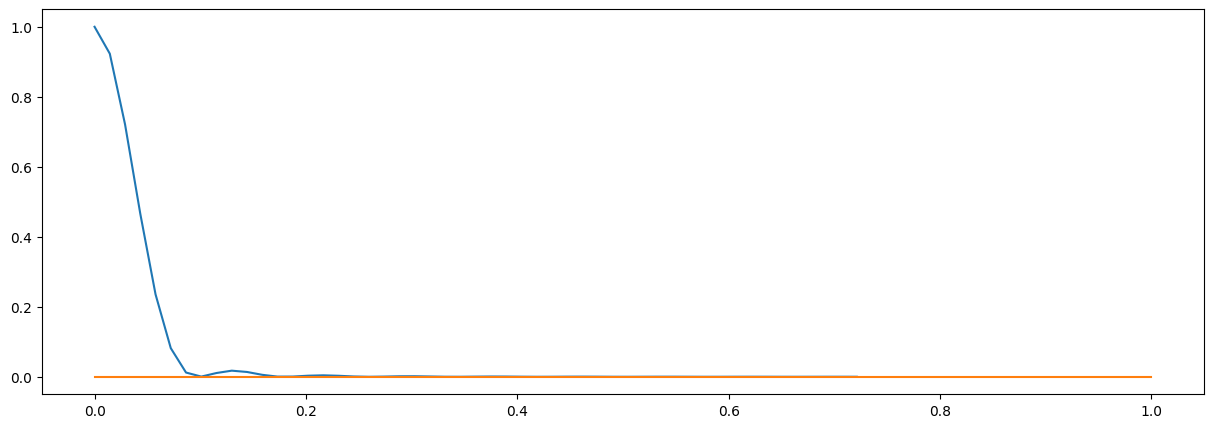

Epoch:  151  Loss:  0.039923764765262604


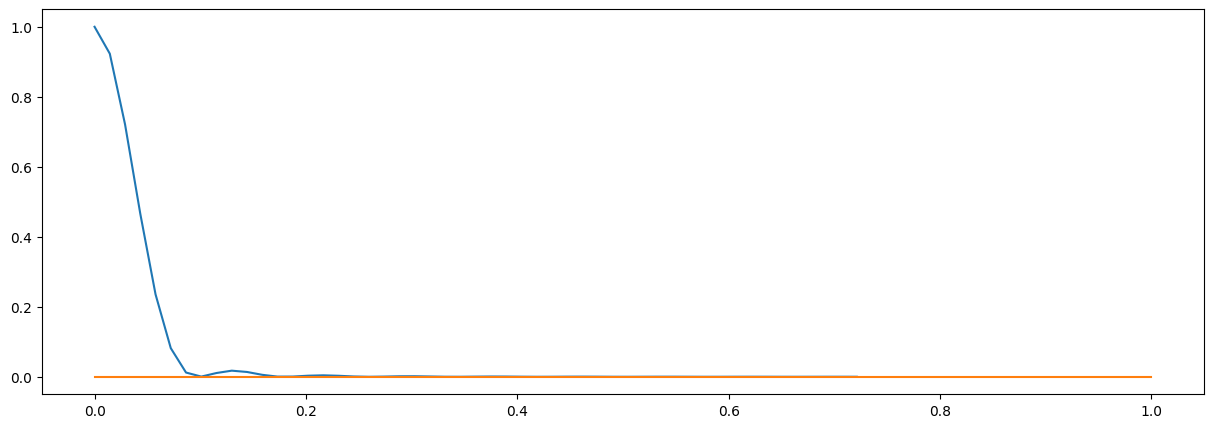

Epoch:  201  Loss:  0.041921455413103104


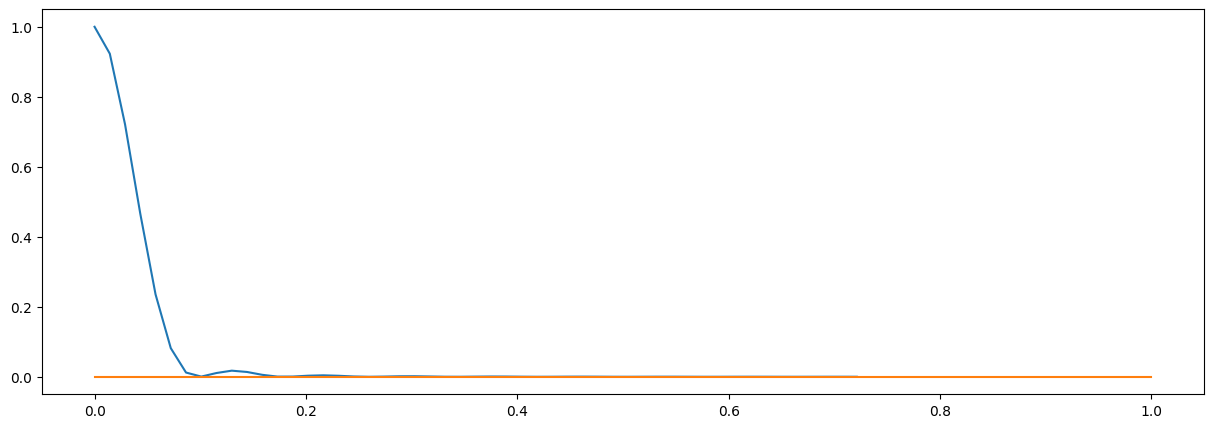

Epoch:  251  Loss:  0.035801141522824764


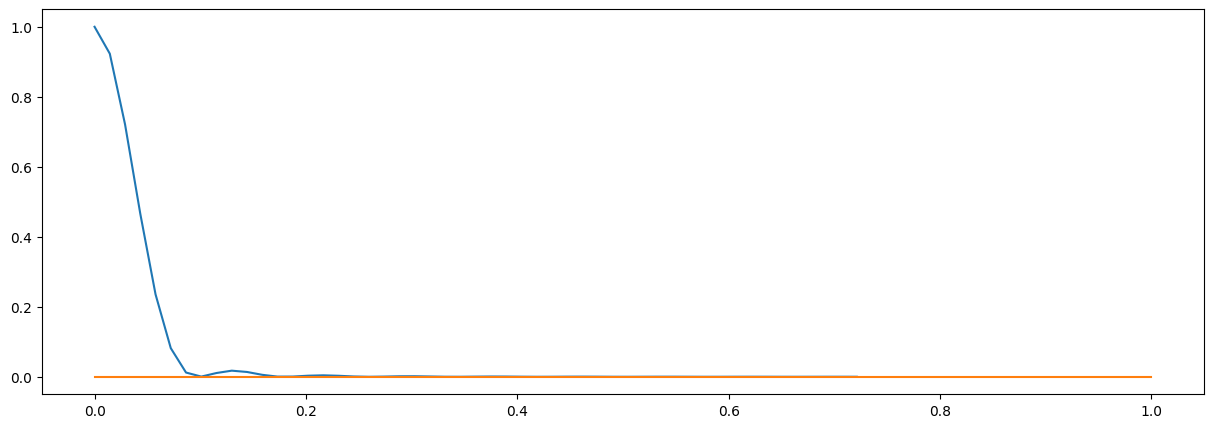

Epoch:  1  Loss:  0.040789151564240456
Epoch:  51  Loss:  0.03845675848424435
Epoch:  101  Loss:  0.037418756633996964
Epoch:  151  Loss:  0.041803985834121704
Epoch:  201  Loss:  0.042373402044177055
Finished Training


In [25]:
#Training loop

EPOCH = 300
timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"

for parameter in model.actual_intensity.parameters():
    parameter.requires_grad = False

for epoch in range(EPOCH):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, outputs = data
        optimizer.zero_grad()
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        running_loss += loss.item()
    if (epoch%50==0): print("Epoch: ",epoch+1, " Loss: ",running_loss)
    if (epoch%50==0):
        #Normalise x axis of original psf to 1
        original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
        original_psf_y = original_psf
        plt.plot(original_psf_x,original_psf_y)

        new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
        new_psf_y = model.getPSF(torch.tensor(new_psf_x))
        new_psf_x = new_psf_x[0]
        new_psf_y = new_psf_y.detach().numpy().flatten()
        plt.plot(new_psf_x,new_psf_y)
        plt.show()


for parameter in model.actual_intensity.parameters():
    parameter.requires_grad = True

for epoch in range(250):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        inputs, outputs = data
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        running_loss += loss.item()
    if (epoch%50==0): print("Epoch: ",epoch+1, " Loss: ",running_loss)
    
print('Finished Training')

loss = criterion(nn_outputs.float(), outputs.float())

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'N': N,
            }, PATH)

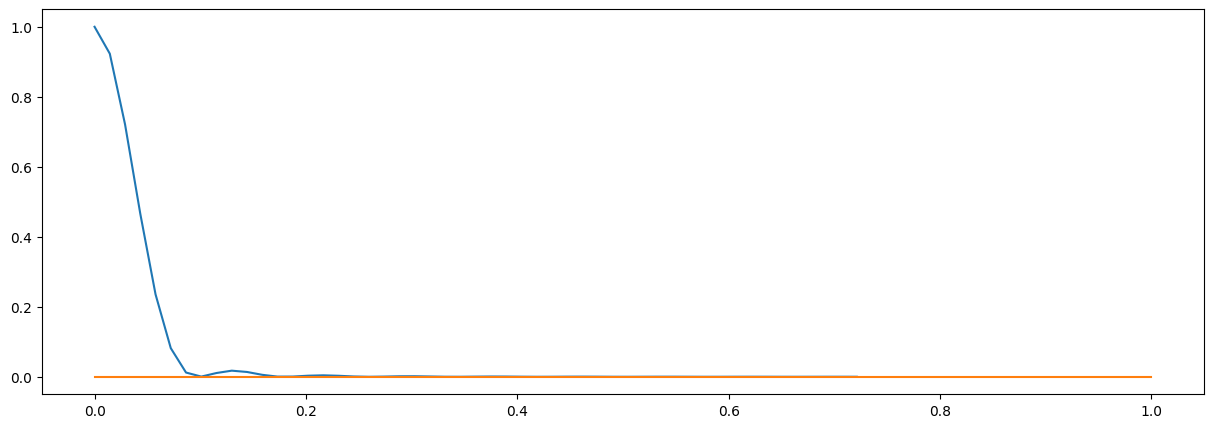

In [26]:
#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
plt.plot(new_psf_x,new_psf_y)
plt.show()


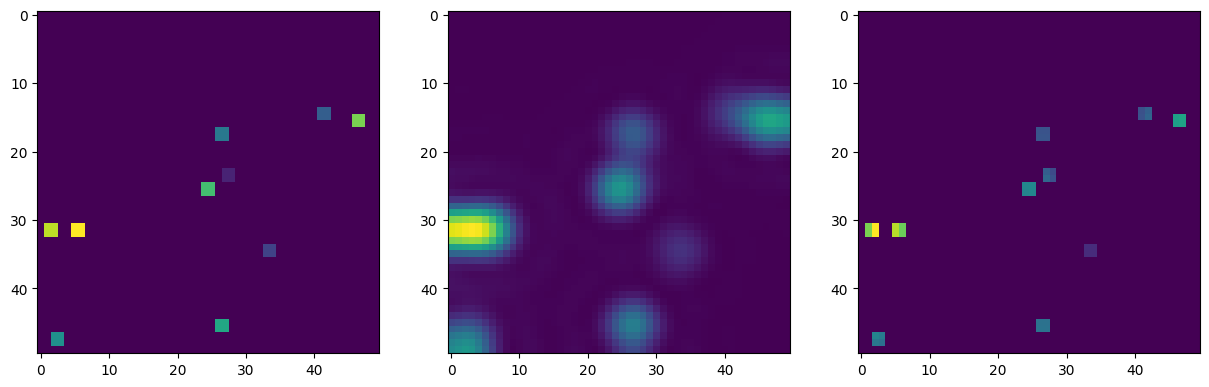

In [27]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros((maskWidth,maskHeight))
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()


array([[1.        , 0.89416603],
       [0.89416603, 1.        ]])

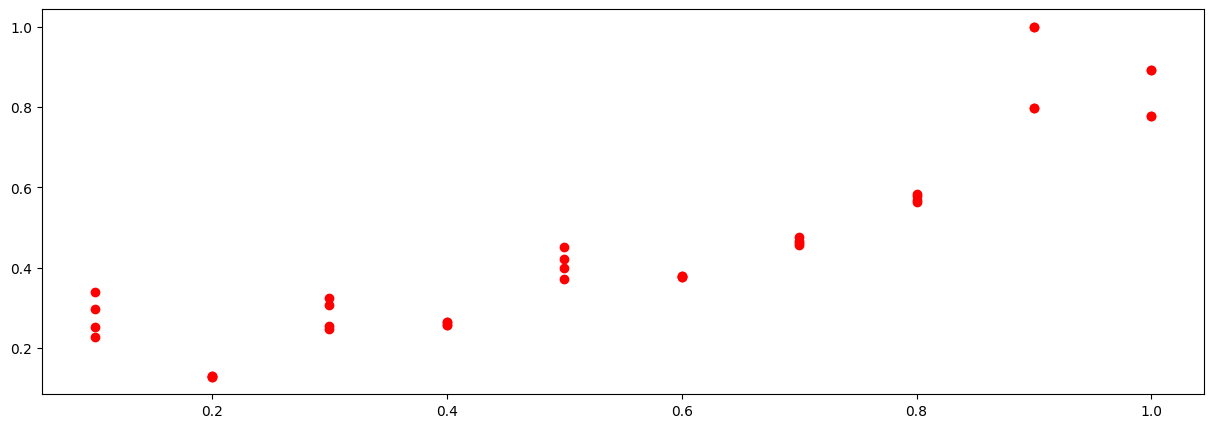

In [28]:
original_intensity = []
custom_intensity = []

for i in range(len(modelIntensity)):
    original_intensity.append(oriNormalised[sourcePts[i][0]][sourcePts[i][1]])
    custom_intensity.append(customOriginal[sourcePts[i][0]][sourcePts[i][1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)